In [1]:
from qiskit.quantum_info import Operator
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit import *
import matplotlib.pyplot as plt 
import numpy as np
import math
import cmath

C:\Users\ASUS\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ASUS\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
C:\Users\ASUS\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
def limDivision(x, y):
    if(y != 0):
        return x/y
    else:
        return 0

In [3]:
#input 2x2 matrix

paramsA = [math.pi, 0, 0]  #pauli-y
true_value1 = [[1/np.sqrt(2)], [1/np.sqrt(2)]]
true_value2 = [[1/np.sqrt(2)], [-1/np.sqrt(2)]]

a11 = 0 
a12 = -1J 
a21 = 1J 
a22 = 0 

A = [[a11, a12], [a21, a22]] 
nShots = 10000

print("The input matrix is", A)

The input matrix is [[0, (-0-1j)], [1j, 0]]


In [4]:
def mapAtoU(A):
    thetaA = 2*math.acos(a11)
    phiA = 1j*cmath.log(limDivision(-a21, cmath.sin(thetaA/2)))
    lambdaA = -1j*cmath.log(limDivision(-a12, cmath.sin(thetaA/2)))
    
    paramsA = [thetaA, phiA, lambdaA]
    
    return paramsA

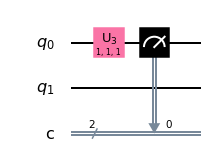

In [5]:
def eigenvectorCircuit(params):
    q = QuantumRegister(2, 'q')
    c = ClassicalRegister(2, 'c')
    qc = QuantumCircuit(q, c, name = 'eigenvectorCircuit')
    qc.u3(params[0], params[1], params[2], 0)
    qc.measure(q[0], c[0])
    return qc

eigenvectorCircuit([1.0, 1.0, 1.0]).draw('mpl')

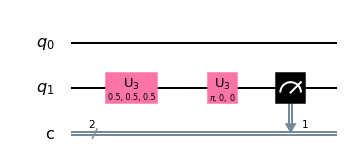

In [6]:
def variationalCircuit(params):
    
    #paramsA = [math.pi, math.pi/2, math.pi/2]  #pauli-y
    #paramsA = [math.pi, 0, 0]  #pauli-x
    #paramsA = [0, math.pi/4, math.pi/4]  #pauli-z
    #paramsA = mapAtoU(A)
    
    q = QuantumRegister(2, 'q')
    c = ClassicalRegister(2, 'c')
    qc = QuantumCircuit(q, c, name = 'variationalCircuit')
    qc.u3(params[0], params[1], params[2], 1)
    qc.u3(paramsA[0], paramsA[1], paramsA[2], 1)
    qc.measure(q[1], c[1])
    return qc
    
variationalCircuit([0.5, 0.5, 0.5]).draw('mpl')

In [9]:
def objective_function(params):
    
    q = QuantumRegister(2, 'q')
    c = ClassicalRegister(2, 'c')
    qc = QuantumCircuit(q, c, name = 'objective_function')
    
    qc.append(eigenvectorCircuit(params), range(2), range(2))
    qc.append(variationalCircuit(params), range(2), range(2))
    
    from qiskit import Aer, execute
    simulator = Aer.get_backend('qasm_simulator')
    counts = execute(qc, backend=simulator, shots=nShots).result().get_counts(qc)
    
    if '01' not in counts:
        counts['01'] = 0
        
    if '10' not in counts:
        counts['10'] = 0
    
    cost = (counts['01'] + counts['10'] - counts['00'] - counts['11']) #maximizing the correlation
                                                                        
    return cost


#objective_function([0.5, 0.5, 0.5], A, 1000).draw('mpl')

In [10]:
from qiskit.aqua.components.optimizers import COBYLA

optimizer = COBYLA(maxiter=10000, tol=0.001/nShots)

params = np.random.rand(3)
ret = optimizer.optimize(num_vars=3, objective_function=objective_function, initial_point=params)

element11 = cmath.cos(ret[0][0]/2)
element21 = cmath.exp(1J*ret[0][1])*cmath.sin(ret[0][0]/2)

#normalizingFactor = 1.0

norm = pow(np.abs(element11), 2) + pow(np.abs(element21), 2)
normalizingFactor = math.sqrt(norm)

eigenvector = [[element11/normalizingFactor], [element21/normalizingFactor]]

diff1 = np.array(true_value1) - np.array(eigenvector)
diff2 = np.array(true_value2) - np.array(eigenvector)

print("Output Error (Manhattan Distance):", ret[1])
print("\nParameters Found:", ret[0])
print("\nNorm:", norm)
print("\nEigenvector Found:", eigenvector)
print("\nDifference:", diff1, "\n\n", diff2)

Output Error (Manhattan Distance): 108.0

Parameters Found: [1.46942998 1.92765557 0.21243624]

Norm: 1.0

Eigenvector Found: [[(0.7420218481126669-0j)], [(-0.23418440644540334+0.6281410993568852j)]]

Difference: [[-0.03491507+0.j       ]
 [ 0.94129119-0.6281411j]] 

 [[-0.03491507+0.j       ]
 [-0.47292237-0.6281411j]]
